In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive/Voice Controlled Home Assistant' 

Mounted at /content/drive
/content/drive/My Drive/Voice Controlled Home Assistant


In [ ]:
!pip install --upgrade grpcio
!pip install tqdm
!pip install sentencepiece
!pip install bert-for-tf2

Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.32.0)
     |████████████████████████████████| 1.1MB 4.5MB/s 
     |████████████████████████████████| 40kB 3.2MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=d03034fbf748195c2b6d588de9acbc90d4a60f77d8a8d111c68a13f6eebdb330
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=423ca5321e3ad412fd537a46a07865438752cf41de742a57ad7abb878b89b694
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=3778fc08f956279b74d23d4836bfa5beb4ea77580f6a36db8f00c34d33b09c21
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06

In [ ]:
import os
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
import seaborn as sns
from pylab import rcParams
from sklearn.metrics import confusion_matrix, classification_report
from random import shuffle
import re
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Process the Fluent.ai Dataset

In [ ]:
import json
import pandas as pd

def make_data(data_type):

    for corpus in data_type:
        all = []
        df_list = pd.read_csv("Fluent/data/"+corpus+"_data.csv").values.tolist()
        for row in df_list:
            all.append([ row[3], row[4], row[5], row[6] ])

        with open("fluent_"+corpus+"_intent.json", 'w') as out_file:
            for i in range(len(all)):
                line = json.dumps({'text': all[i][0], 'action': all[i][1], 'object': all[i][2], 'location': all[i][3]})
                out_file.write(line + '\n')

make_data(['train', 'valid', 'test'])

In [ ]:
df_list = pd.read_csv("Fluent/data/train_data.csv")
df_list

,Unnamed: 0,path,speakerId,transcription,action,object,location
0,0,wavs/speakers/2BqVo8kVB2Skwgyb/0a3129c0-4474-1...,2BqVo8kVB2Skwgyb,Change language,change language,none,none
1,1,wavs/speakers/2BqVo8kVB2Skwgyb/0ee42a80-4474-1...,2BqVo8kVB2Skwgyb,Resume,activate,music,none
2,2,wavs/speakers/2BqVo8kVB2Skwgyb/144d5be0-4474-1...,2BqVo8kVB2Skwgyb,Turn the lights on,activate,lights,none
3,3,wavs/speakers/2BqVo8kVB2Skwgyb/1811b6e0-4474-1...,2BqVo8kVB2Skwgyb,Switch on the lights,activate,lights,none
4,4,wavs/speakers/2BqVo8kVB2Skwgyb/1d9f3920-4474-1...,2BqVo8kVB2Skwgyb,Switch off the lights,deactivate,lights,none
...,...,...,...,...,...,...,...
23127,23127,wavs/speakers/zZezMeg5XvcbRdg3/b946b340-45e0-1...,zZezMeg5XvcbRdg3,I need to practice my Chinese. Switch the lang...,change language,Chinese,none
23128,23128,wavs/speakers/zZezMeg5XvcbRdg3/beb27cb0-45e0-1...,zZezMeg5XvcbRdg3,I need to practice my German. Switch the language,change language,German,none
23129,23129,wavs/speakers/zZezMeg5XvcbRdg3/c45f94e0-45e0-1...,zZezMeg5XvcbRdg3,I need to practice my Korean. Switch the language,change language,Korean,none
23130,23130,wavs/speakers/zZezMeg5XvcbRdg3/ca60c080-45e0-1...,zZezMeg5XvcbRdg3,I need to practice my English. Switch the lang...,change language,English,none


In [ ]:
def load_data(desc_file):
    # Load Data from Json file
    texts, actions, objects, locations = [], [], [], []
    with open(desc_file) as json_line_file:
        for line_num, json_line in enumerate(json_line_file):
            try:
                spec = json.loads(json_line)
                texts.append(spec['text'])
                actions.append(spec['action'])
                objects.append(spec['object'])
                locations.append(spec['location'])
            except Exception as e:
                print('Error reading line #{}: {}'
                            .format(line_num, json_line))
    return texts, actions, objects, locations

def make_data_seperated(data_type):

    all_dfs = []
    for corpus in data_type:
        inputs = pd.read_csv("Fluent/data/"+corpus+"_data.csv").drop(columns=['Unnamed: 0', 'action', 'object', 'location', 'path', 'speakerId']).values.tolist()
        labels = pd.read_csv("Fluent/data/"+corpus+"_data.csv").drop(columns=['Unnamed: 0', 'transcription', 'path', 'speakerId', 'location']).values.tolist()

        all_labels, all_inputs = [], []
        
        for row in labels:
            row = ' '.join(row)
            all_labels.append(row)

        for input in inputs:
            for inpt in input:
                all_inputs.append(inpt)

        data = []
        for inp, lbl in zip(all_inputs, all_labels):
            data.append( [inp, lbl] )

        df = pd.DataFrame(data,columns=['text', 'intent'])
        all_dfs.append(df)
    
    return all_dfs, all_labels

def removeClasses(alist, data):

    dfs = []
    df = data[~data['intent'].isin(alist)]

    return df

In [ ]:
all_dfs, all_labels = make_data_seperated(['train', 'valid', 'test'])
data = pd.concat([all_dfs[0], all_dfs[1], all_dfs[2]])
print("Data Length : ", len(data.values.tolist()))
list_data = data.values.tolist()

Data Length :  30043


Text(0, 0.5, 'Intents')

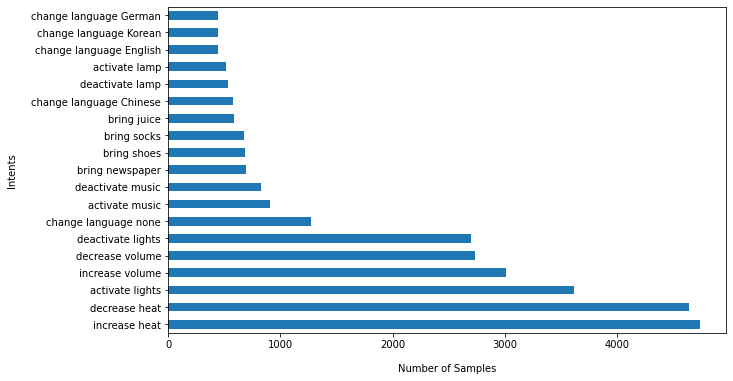

In [ ]:
import matplotlib.pyplot as plt

data['intent'].value_counts().plot(kind='barh', figsize=(10, 6))
plt.xlabel("Number of Samples", labelpad=14)
plt.ylabel("Intents", labelpad=14)

In [ ]:
data = removeClasses(['change language German', 
            'change language Korean', 
            'change language none', 
            'change language Chinese',
            'change language English',
            'bring juice',
            'activate music',
            'deactivate music',
            'bring shoes',
            'bring socks',
            'bring newspaper',
            'activate lamp',
            'deactivate lamp'], data)

list_data = data.values.tolist()

In [ ]:
entry_data = []

for el in data.values.tolist():
    if el[1] == 'activate lights':
        entry_data.append([el[0], 'lightsOn'])
    elif el[1] == 'deactivate lights':
        entry_data.append([el[0], 'lightsOff'])
    elif el[1] == 'increase heat':
        entry_data.append([el[0], 'heatinOn'])
    elif el[1] == 'decrease heat':
        entry_data.append([el[0], 'heatingOff'])
    elif el[1] == 'bring juice':
        entry_data.append([el[0], 'makeBeverage'])
    elif el[1] == 'increase volume':
        entry_data.append([el[0], 'volumeUp'])
    elif el[1] == 'decrease volume':
        entry_data.append([el[0], 'volumeDown'])

data = pd.DataFrame(entry_data,columns=['text', 'intent'])
list_data = data.values.tolist()

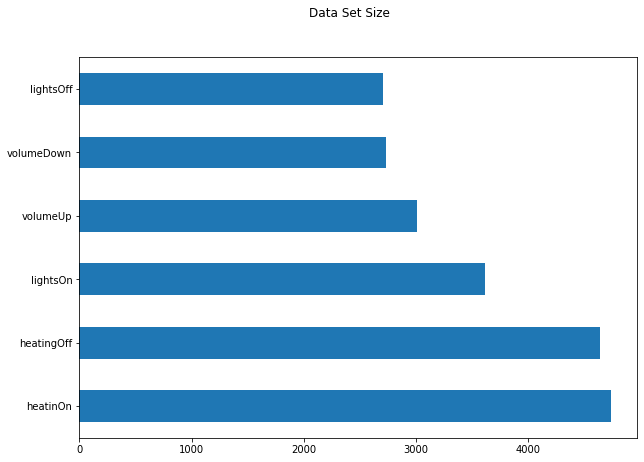

In [ ]:
import matplotlib.pyplot as plt

data['intent'].value_counts().plot(kind='barh', figsize=(10, 7))
plt.suptitle('Data Set Size')
plt.show()

## Removing duplicates

In [ ]:
list_data

[['Turn the lights on', 'lightsOn'],
 ['Switch on the lights', 'lightsOn'],
 ['Switch off the lights', 'lightsOff'],
 ['Volume up', 'volumeUp'],
 ['Turn the volume up', 'volumeUp'],
 ['Turn the volume down', 'volumeDown'],
 ['Turn up the temperature', 'heatinOn'],
 ['Turn the heat up', 'heatinOn'],
 ['Turn down the temperature', 'heatingOff'],
 ['Turn the temperature down', 'heatingOff'],
 ['Turn down the heat', 'heatingOff'],
 ['Turn the heat down', 'heatingOff'],
 ['Turn on the kitchen lights', 'lightsOn'],
 ['Switch on the kitchen lights', 'lightsOn'],
 ['Turn the lights on in the kitchen', 'lightsOn'],
 ['Switch on the lights in the kitchen', 'lightsOn'],
 ['Lights on in the kitchen', 'lightsOn'],
 ['Kitchen lights on', 'lightsOn'],
 ['Switch the kitchen lights on', 'lightsOn'],
 ['Turn the kitchen lights on', 'lightsOn'],
 ['Turn on the lights in the bedroom', 'lightsOn'],
 ['Switch on the lights in the bedroom', 'lightsOn'],
 ['Turn on the washroom lights', 'lightsOn'],
 ['Turn t

In [ ]:
def deduplicate_by_ip(a):
    """
    Clears Empty ip address records from list
    removes duplicates by
    :param a:
    :return:
    """

    source_ips = []
    new_list = []
    for i in range(len(a)):
        if a[i][0] != None:
            if a[i][0] not in source_ips:
                source_ips.append(a[i][0])
                new_list.append(a[i])
    return new_list

new_list = deduplicate_by_ip(list_data)
print("Total items in original list :", len(list_data))
print("Total items after deduplication :", len(new_list))
# print("The list", list)

Total items in original list : 21432
Total items after deduplication : 175


In [ ]:
len([list(x) for x in {(tuple(e)) for e in list_data}])

175

# Process Created Dataset

In [ ]:
df = pd.read_csv("gathered_data.csv").drop(columns=['Horodateur', 'Full Name (If you want ;) )', 'airCondOn', 'airCondOff'])
df.head()

,lightsOn,lightsOff,makeBeverage,CameraOn,heatinOn,heatingOff
0,I need some lights; give me some lights; light...,shut down the lights;I need this room to be da...,I'm thirsty; I need to drink something; I woul...,could you tell me who's at the door ?; show me...,activate the heating system,deactivate the heating system
1,hello,Good night,Water please,Knock knock,Applause,that heater been working for too long shut it ...
2,lights on,lights off,bring me some water; could you bring me some w...,check who's outside; check who's knocking on t...,could this be any colder,turn the air-conditioner up to 20
3,would you please switch on the light,would you please hit the light,can i get a drink please,who's there,its too cold would you please make it warmer f...,Okay its warm enough now
4,Lights on;Turn on the lights,Lights off; I'm leaving;Turn off the lights,I'm thirsty;I need a drink;I need something to...,Who's outside;Is anyone outside,Turn on/off the air conditioner,shut down the warming machine


In [ ]:
ent_data = []

def df2Set(df):
    ent_data2 = []
    text = []
    intent = []

    for col in df:
        for row in df[col]:
            try:
                row = row.split(';')
                for element in row:
                    ent_data2.append([re.sub(r"[^a-zA-Z0-9]+", ' ', element), col])
                    text.append(re.sub(r"[^a-zA-Z0-9]+", ' ', element))
                    intent.append(col)
            except Exception as e:
                print(e)
    ent_data.append(['dim the lights', 'lightsOff'])
    return ent_data2, text, intent

ent_data, text, intent = df2Set(df)

'float' object has no attribute 'split'
'float' object has no attribute 'split'
'float' object has no attribute 'split'
'float' object has no attribute 'split'
'float' object has no attribute 'split'
'float' object has no attribute 'split'


In [ ]:
ent_data

[['I need some lights', 'lightsOn'],
 [' give me some lights', 'lightsOn'],
 [' lights on', 'lightsOn'],
 [' hello ', 'lightsOn'],
 ['lights on', 'lightsOn'],
 ['would you please switch on the light', 'lightsOn'],
 ['Lights on', 'lightsOn'],
 ['Turn on the lights', 'lightsOn'],
 ['Lights on ', 'lightsOn'],
 ['Lights on ', 'lightsOn'],
 ['Turn the lights in the living room ', 'lightsOn'],
 [' or with a simple clap it will turn on the lights ', 'lightsOn'],
 ['It s dark give me some lights', 'lightsOn'],
 ['Lights', 'lightsOn'],
 [' lights on', 'lightsOn'],
 [' need some light', 'lightsOn'],
 [' can u help me see', 'lightsOn'],
 [' don t have night vision', 'lightsOn'],
 [' on', 'lightsOn'],
 ['Lights on', 'lightsOn'],
 ['Lights on ', 'lightsOn'],
 ['Allume les lumi res de cette chambre ', 'lightsOn'],
 ['Lights on', 'lightsOn'],
 [' make it the room shine ', 'lightsOn'],
 ['Lights please ', 'lightsOn'],
 ['Activate the lights', 'lightsOn'],
 ['light on', 'lightsOn'],
 ['lights on please

In [ ]:
ent_data = [list(x) for x in {(tuple(e)) for e in ent_data}]

In [ ]:
print("Data Shape : ", np.array(ent_data).shape)
# Shuffle Set

shuffle(ent_data)

# train = ent_data[0:int(len(ent_data)*0.75)]
# test = ent_data[int(len(ent_data)*0.75):len(ent_data)]

# print("Shape of Training Set : ",np.array(train).shape)
# print("Shape of Testing Set : ",np.array(test).shape)

created_data = pd.DataFrame(ent_data,columns=['text', 'intent'])
created_data_2 = pd.DataFrame(new_list,columns=['text', 'intent'])

# train_df = pd.DataFrame(train,columns=['text', 'intent'])
# test_df = pd.DataFrame(test,columns=['text', 'intent'])

Data Shape :  (196, 2)


In [ ]:
created_data

,text,intent
0,turn it off,lightsOff
1,Drink,makeBeverage
2,house is warm now stop it,heatingOff
3,It s getting cold turn on the heating system,heatinOn
4,I want the room dark,lightsOff
...,...,...
177,Something to drink,makeBeverage
178,Active la camera De la porte et v rifie qui es...,CameraOn
179,Who s outside,CameraOn
180,Turn off the lights please,lightsOff


In [ ]:
from sklearn.model_selection import train_test_split

# Combine both the datasets
all_the_data = pd.concat([created_data, created_data_2])

new_row = [{'text': 'could that door be any broken', 'intent': 'CameraOn'},
           {'text': 'i am thirsty', 'intent': 'makeBeverage'},
           {'text': "it's hot in here", 'intent': 'airCondOn'},
           {'text': 'AC off please', 'intent': 'airCondOff'},
           {'text': "who's knocking", 'intent': 'CameraOn'},
           {'text': 'could that room be any brighter', 'intent': 'lightsOff'},
           {'text': 'could that room be any darker', 'intent': 'lightsOn'},
           {'text': 'could that room be any hotter', 'intent': 'airCondOn'},
           {'text': 'could that romm be any colder', 'intent': 'airCondOff'},
           {'text': 'show me the door would you', 'intent': 'CameraOn'}]

for row in new_row:
    IntentData = all_the_data.append(new_row, ignore_index=True)

len(IntentData)

381

In [ ]:
IntentData.to_excel("INTENTDATA_FINAL.xls")

In [ ]:
IntentData = pd.read_excel("INTENTDATA_FINAL.xls")

In [ ]:
len(IntentData),len(IntentData.drop_duplicates(subset=['text']))

(22207, 368)

In [ ]:
# Split df
# IntentData = IntentData.drop_duplicates(subset=['text'])
IntentData_train = IntentData.sample(frac=1).iloc[:int(len(IntentData)*0.8)]
IntentData_test = IntentData.sample(frac=1).iloc[int(len(IntentData)*0.8):len(IntentData)]

print(len(IntentData_train), len(IntentData_test))

print(list(set(IntentData_train['intent'])))
print(list(set(IntentData_test['intent'])))

304 77
['lightsOn', 'CameraOn', 'makeBeverage', 'volumeUp', 'lightsOff', 'heatingOff', 'heatinOn', 'airCondOn', 'volumeDown', 'airCondOff']
['lightsOn', 'CameraOn', 'makeBeverage', 'volumeUp', 'lightsOff', 'heatingOff', 'heatinOn', 'airCondOn', 'volumeDown', 'airCondOff']


In [ ]:
import os

bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [ ]:
class IntentDetectionData:
    DATA_COLUMN = "text"
    LABEL_COLUMN = "intent"

    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes

        train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])

        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

    def _prepare(self, df):
        x, y = [], []

        for _, row in tqdm(df.iterrows()):
            text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
          input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
          input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
          x.append(np.array(input_ids))
        return np.array(x)

In [ ]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [ ]:
data = IntentDetectionData(IntentData_train, IntentData_test, tokenizer, list(set(IntentData_train['intent'])), max_seq_len=192)

304it [00:00, 4604.76it/s]
77it [00:00, 4100.47it/s]

max seq_len 28


# Modeling with BERT

## Create Model

In [ ]:
def create_model(max_seq_len, bert_ckpt_file, classes):

    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
            
    input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)

    print("bert shape", bert_output.shape)

    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.1)(cls_out)
    logits = keras.layers.Dense(units=64, activation="relu")(cls_out)
    logits = keras.layers.Dropout(0.1)(logits)
    logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))

    load_stock_weights(bert, bert_ckpt_file)
    model.summary()
    return model

model = create_model(data.max_seq_len, bert_ckpt_file, classes=list(set(IntentData_train['intent'])))

NameError: ignored

In [ ]:
model = create_model(28, bert_ckpt_file, classes=['CameraOn', 'heatingOff', 'volumeDown', 'makeBeverage', 'airCondOn', 'heatinOn', 'lightsOff', 'airCondOff', 'lightsOn', 'volumeUp'])

bert shape (None, 28, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f186da4ca20> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 28)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 28, 768)    

In [ ]:
# List Of Callbacks

model_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="log/intentDet",
    save_weights_only=True,
    monitor="val_acc",
    save_best_only=True
)

log_dir = "logs" + datetime.datetime.now().strftime("%Y%m%d")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
# TQDM_callback = tfa.callbacks.TQDMProgressBar()

model_cb_es = tf.keras.callbacks.EarlyStopping(
    restore_best_weights=True,
    monitor="val_acc",
)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

history = model.fit(
    x = data.train_x, 
    y = data.train_y,   
    validation_split = 0.2,
    batch_size = 2,
    epochs = 10,
    callbacks = [model_cb]
)

Epoch 1/10
122/122 [==============================] - 44s 361ms/step - loss: 2.2762 - acc: 0.1564 - val_loss: 2.1383 - val_acc: 0.3770
Epoch 2/10
122/122 [==============================] - 55s 454ms/step - loss: 2.0385 - acc: 0.4486 - val_loss: 1.9393 - val_acc: 0.5246
Epoch 3/10
122/122 [==============================] - 55s 451ms/step - loss: 1.8865 - acc: 0.5761 - val_loss: 1.9090 - val_acc: 0.5574
Epoch 4/10
122/122 [==============================] - 60s 495ms/step - loss: 1.7627 - acc: 0.7243 - val_loss: 1.8915 - val_acc: 0.5738
Epoch 5/10
122/122 [==============================] - 56s 460ms/step - loss: 1.6844 - acc: 0.7984 - val_loss: 1.8539 - val_acc: 0.6066
Epoch 6/10
122/122 [==============================] - 59s 484ms/step - loss: 1.6200 - acc: 0.8642 - val_loss: 1.6843 - val_acc: 0.8033
Epoch 7/10
122/122 [==============================] - 58s 477ms/step - loss: 1.5514 - acc: 0.9300 - val_loss: 1.5594 - val_acc: 0.9180
Epoch 8/10
122/122 [==============================] - 5

In [ ]:
model.save("intent_rec.h5")
model.save_weights("intent_rec_weights.h5")

In [ ]:
model.load_weights("intent_rec_weights.h5")

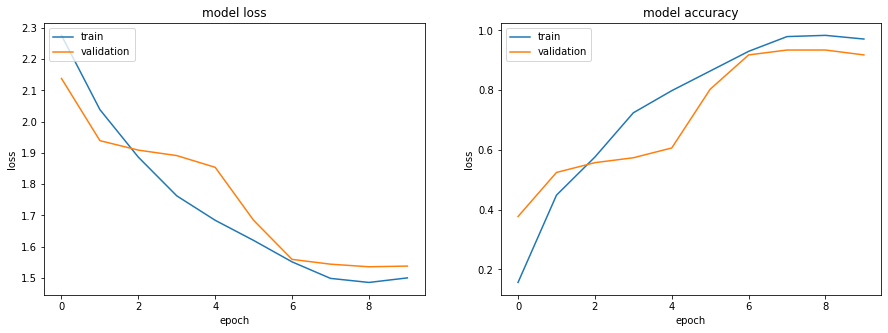

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("Model Test Accuracy : ", test_acc)

3/3 [==============================] - 0s 52ms/step - loss: 1.4980 - acc: 0.9610
Model Test Accuracy :  0.9610389471054077


In [ ]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

print(classification_report(data.test_y, y_pred, target_names=list(set(IntentData_test['intent'])) ))

              precision    recall  f1-score   support

   lightsOff       0.89      1.00      0.94         8
    heatinOn       1.00      1.00      1.00        19
    volumeUp       0.75      1.00      0.86         6
makeBeverage       1.00      1.00      1.00         8
  heatingOff       1.00      1.00      1.00        10
  volumeDown       1.00      1.00      1.00         7
    CameraOn       1.00      0.67      0.80         6
    lightsOn       1.00      0.92      0.96        13

    accuracy                           0.96        77
   macro avg       0.95      0.95      0.94        77
weighted avg       0.97      0.96      0.96        77



# Predict

In [ ]:
def process(sentences):
    pred_tokens = map(tokenizer.tokenize, sentences)
    pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
    pred_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

    pred_tokens_ids = map(lambda tids: tids + [0]*(28-len(tids)), pred_tokens_ids)
    pred_tokens_ids = np.array(list(pred_tokens_ids))
    return pred_tokens_ids

In [ ]:
model.load_weights("intent_rec_weights.h5")

sentences = input("Enter : ")
# sentences = ["could that room be any brighter"]
sentences = sentences.split('and')

print("\nProcessing...")

pred_tokens_ids = process(sentences)

print("Processing done")

print("-"*80)
print("Predicting...")
predictions = model.predict(pred_tokens_ids).argmax(axis=-1)
print("Prediction done")

print("-"*80)
print("Prediction Results : \n")

for text, label in zip(sentences, predictions):
    print("Text : ", text, " => Intent : ", ['CameraOn', 'heatingOff', 'volumeDown', 'makeBeverage', 'airCondOn', 'heatinOn', 'lightsOff', 'airCondOff', 'lightsOn', 'volumeUp'][label])

# KNN

In [ ]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import genesis
nltk.download('genesis')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
genesis_ic = wn.ic(genesis, False, 0.0)

import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import stopwords
from sklearn.metrics import roc_auc_score

[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Unzipping corpora/genesis.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
class KNN_NLC_Classifer():
    def __init__(self, k=1, distance_type = 'path'):
        self.k = k
        self.distance_type = distance_type

    # This function is used for training
    def fit(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

    # This function runs the K(1) nearest neighbour algorithm and
    # returns the label with closest match. 
    def predict(self, x_test):
        self.x_test = x_test
        y_predict = []

        for i in range(len(x_test)):
            max_sim = 0
            max_index = 0
            for j in range(np.array(self.x_train).shape[0]):
                temp = self.document_similarity(x_test[i], self.x_train[j])
                if temp > max_sim:
                    max_sim = temp
                    max_index = j
            y_predict.append(self.y_train[max_index])
        return y_predict

    def convert_tag(self, tag):
        tag_dict = {'N': 'n', 'J': 'a', 'R': 'r', 'V': 'v'}
        try:
            return tag_dict[tag[0]]
        except KeyError:
            return None


    def doc_to_synsets(self, doc):
        tokens = word_tokenize(doc+' ')
        
        l = []
        tags = nltk.pos_tag([tokens[0] + ' ']) if len(tokens) == 1 else nltk.pos_tag(tokens)
        
        for token, tag in zip(tokens, tags):
            syntag = self.convert_tag(tag[1])
            syns = wn.synsets(token, syntag)
            if (len(syns) > 0):
                l.append(syns[0])
        return l  

    def similarity_score(self, s1, s2, distance_type = 'path'):
        """
        Calculate the normalized similarity score of s1 onto s2
        For each synset in s1, finds the synset in s2 with the largest similarity value.
        Sum of all of the largest similarity values and normalize this value by dividing it by the
        number of largest similarity values found.

        Args:
            s1, s2: list of synsets from doc_to_synsets

        Returns:
            normalized similarity score of s1 onto s2
        """
        s1_largest_scores = []

        for i, s1_synset in enumerate(s1, 0):
            max_score = 0
            for s2_synset in s2:
                if distance_type == 'path':
                    score = s1_synset.path_similarity(s2_synset, simulate_root = False)
                else:
                    score = s1_synset.wup_similarity(s2_synset)                  
                if score != None:
                    if score > max_score:
                        max_score = score
            
            if max_score != 0:
                s1_largest_scores.append(max_score)
        
        mean_score = np.mean(s1_largest_scores)
                
        return mean_score 

    def document_similarity(self,doc1, doc2):
        """Finds the symmetrical similarity between doc1 and doc2"""

        synsets1 = self.doc_to_synsets(doc1)
        synsets2 = self.doc_to_synsets(doc2)
        
        return (self.similarity_score(synsets1, synsets2) + self.similarity_score(synsets2, synsets1)) / 2

## Train

In [ ]:
# nltk.download('stopwords')
# s = stopwords.words('english')
# s.extend(['today', 'tomorrow', 'outside', 'out', 'there'])
# ps = nltk.wordnet.WordNetLemmatizer()

x = data.train_x, 
y = data.train_y,

In [ ]:
# 4. Train the Classifier
classifier = KNN_NLC_Classifer(k=2, distance_type='path')
classifier.fit(train['text'].values.tolist(), train['intent'].values.tolist())

In [ ]:
train['text'].values.tolist()

In [ ]:
final_test_list = ["give me brightness", "stop the lights", "i am thirsty", "is someone knocking ?", "It's a gazillion degrees here",
                   "If the cold keeps on i will die", "it's so dark in this room do something", "could that door be any broken", "could that room be any brigther"]

test_corpus = []

for i in range(len(final_test_list)):
    review = re.sub('[^a-zA-Z]', ' ', final_test_list[i])
    review = review.lower()
    review = review.split()

    # review = [ps.lemmatize(word) for word in review if not word in s]
    review = ' '.join(review)
    test_corpus.append(review)

y_pred_final = classifier.predict( test_corpus )

output_df = pd.DataFrame(data = {'text': final_test_list, 'code': y_pred_final})

print(output_df)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


                                     text          code
0                      give me brightness      lightsOn
1                         stop the lights      lightsOn
2                            i am thirsty  makeBeverage
3                   is someone knocking ?      CameraOn
4           It's a gazillion degrees here     airCondOn
5         If the cold keeps on i will die      heatinOn
6  it's so dark in this room do something    heatingOff
7           could that door be any broken      CameraOn
8         could that room be any brigther      CameraOn
